<a href="https://colab.research.google.com/github/Saisha0512/Portfolio_Optimization_ML_DL/blob/main/Portfolio_Optimization_ML_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Problem Statement**

# **2. Data Collection**

In [312]:
# Installing yfinance
!pip install yfinance

In [313]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [314]:
import yfinance as yf
import pandas as pd

# Define the ticker symbols
tickers = ['AAPL', 'MSFT', 'AMZN', 'META']

# Set the time period
start_date = '2012-01-03'
end_date = '2021-12-31'

# Download OHLCV data and ensure datetime index
data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)

    # Ensure the index is datetime
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    # Save to CSV
    df.to_csv(f"{ticker}_historical_OHLCV_data.csv")

    # Store in dictionary
    data[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [349]:
import yfinance as yf
import pandas as pd

# List of tickers
tickers = ['AAPL', 'MSFT', 'AMZN', 'META']

# Date range
start_date = '2012-01-03'
end_date = '2021-12-31'

# Download OHLCV data in wide format
df = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

# Convert to long format
all_data = []

for ticker in tickers:
    temp_df = df[ticker].copy()
    temp_df['Company'] = ticker
    temp_df.reset_index(inplace=True)  # Keep 'Date' as a column
    all_data.append(temp_df)

# Combine into one DataFrame
stock_data = pd.concat(all_data)

# Ensure correct order of columns
stock_data = stock_data[['Date', 'Company', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Save to CSV if needed
stock_data.to_csv("stock_data.csv", index=False)

print(stock_data.head())


[*********************100%***********************]  4 of 4 completed


Price       Date Company       Open       High        Low      Close  \
0     2012-01-03    AAPL  12.304184  12.397352  12.292162  12.359182   
1     2012-01-04    AAPL  12.322214  12.462868  12.300575  12.425600   
2     2012-01-05    AAPL  12.470987  12.579182  12.402463  12.563554   
3     2012-01-06    AAPL  12.615850  12.705411  12.599320  12.694892   
4     2012-01-09    AAPL  12.788056  12.855678  12.663330  12.674751   

Price       Volume  
0      302220800.0  
1      260022000.0  
2      271269600.0  
3      318292800.0  
4      394024400.0  


In [315]:
# Displaying the AGG data
data['AAPL'].head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.359182,12.397352,12.292162,12.304184,302220800
2012-01-04,12.425600,12.462868,12.300575,12.322214,260022000
2012-01-05,12.563554,12.579182,12.402463,12.470987,271269600
2012-01-06,12.694892,12.705411,12.599320,12.615850,318292800
2012-01-09,12.674751,12.855678,12.663330,12.788056,394024400


In [316]:
# Displaying the AGG data
data['MSFT'].head()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2012-01-03,21.039206,21.188530,20.740553,20.866301,64731500
2012-01-04,21.534336,21.589351,21.047064,21.078500,80516100
2012-01-05,21.754393,21.793688,21.447883,21.518614,56081400
2012-01-06,22.092342,22.155216,21.636506,21.636506,99455500
2012-01-09,21.801554,22.084487,21.785835,22.045190,59706800


In [317]:
# Displaying the AGG data
data['AMZN'].head()

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2012-01-03,8.9515,8.9740,8.7775,8.7945,102216000
2012-01-04,8.8755,9.0250,8.8035,8.9605,84104000
2012-01-05,8.8805,8.9125,8.7025,8.7970,76182000
2012-01-06,9.1305,9.2325,8.8750,8.9035,140168000
2012-01-09,8.9280,9.2185,8.8500,9.1380,101138000


In [318]:
# Displaying the AGG data
data['META'].head()

Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2012-05-18,38.021412,44.754474,37.792667,41.820569,573576400
2012-05-21,33.844326,36.459977,32.819947,36.330686,168192700
2012-05-22,30.830860,33.406729,30.771188,32.432076,101786600
2012-05-23,31.825405,32.322677,31.188898,31.198843,73600000
2012-05-24,32.849785,33.028803,31.596661,32.770223,50237200


# **3. Data Preprocessing**

In [319]:
# Reading all the CSV Files individually
aapl = pd.read_csv("AAPL_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
msft = pd.read_csv("MSFT_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
amzn = pd.read_csv("AMZN_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
meta = pd.read_csv("META_historical_OHLCV_data.csv", index_col=0, parse_dates=True)

In [320]:
"""# Preprocessing Function for Each Asset
def preprocess_asset(df, asset_name):
    df = df.copy()

    # Convert relevant columns to numeric (errors='coerce' converts non-numeric to NaN)
    cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill missing values
    df = df.ffill().bfill() # Forward & Backward filling

    # Sort by datetime
    df = df.sort_index()

    # Calculate features using 'Close'
    df['Daily Return'] = np.log(df['Close'] / df['Close'].shift(1)).dropna()
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Rolling Volatility'] = df['Daily Return'].rolling(window=30).std() * np.sqrt(252)

    # Add prefix to all columns
    df = df.add_prefix(f'{asset_name}_')

    return df
"""

"# Preprocessing Function for Each Asset\ndef preprocess_asset(df, asset_name):\n    df = df.copy()\n\n    # Convert relevant columns to numeric (errors='coerce' converts non-numeric to NaN)\n    cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']\n    for col in cols_to_convert:\n        df[col] = pd.to_numeric(df[col], errors='coerce')\n\n    # Fill missing values\n    df = df.ffill().bfill() # Forward & Backward filling\n\n    # Sort by datetime\n    df = df.sort_index()\n\n    # Calculate features using 'Close'\n    df['Daily Return'] = np.log(df['Close'] / df['Close'].shift(1)).dropna()\n    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()\n    df['MA10'] = df['Close'].rolling(window=10).mean()\n    df['MA50'] = df['Close'].rolling(window=50).mean()\n    df['Rolling Volatility'] = df['Daily Return'].rolling(window=30).std() * np.sqrt(252)\n\n    # Add prefix to all columns\n    df = df.add_prefix(f'{asset_name}_')\n\n    return df\n"

In [321]:
'''# Apply Preprocessing to Each Asset
aapl_clean = preprocess_asset(aapl, 'AAPL')
msft_clean = preprocess_asset(msft, 'MSFT')
amzn_clean = preprocess_asset(amzn, 'AMZN')
meta_clean = preprocess_asset(meta, 'META')
'''

"# Apply Preprocessing to Each Asset\naapl_clean = preprocess_asset(aapl, 'AAPL')\nmsft_clean = preprocess_asset(msft, 'MSFT')\namzn_clean = preprocess_asset(amzn, 'AMZN')\nmeta_clean = preprocess_asset(meta, 'META')\n"

In [322]:
aapl.index.name = 'Date'
aapl.head()

,Close,High,Low,Open,Volume
Date,,,,,
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,NaN,NaN,NaN,NaN,NaN
2012-01-03,12.359182357788086,12.397351644697126,12.292161998269554,12.30418394730127,302220800
2012-01-04,12.425600051879883,12.46286808917538,12.30057500786009,12.322213710853296,260022000
2012-01-05,12.563553810119629,12.579181545225902,12.40246286304358,12.470987187084512,271269600


In [323]:
msft.index.name = 'Date'
msft.head()

,Close,High,Low,Open,Volume
Date,,,,,
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,NaN,NaN,NaN,NaN,NaN
2012-01-03,21.03920555114746,21.188530171745544,20.74055331188635,20.866301149775513,64731500
2012-01-04,21.53433609008789,21.58935057824609,21.04706362437323,21.078499832306896,80516100
2012-01-05,21.754392623901367,21.793688253305938,21.44788251725561,21.518614350377405,56081400


In [324]:
amzn.index.name = 'Date'
amzn.head()

,Close,High,Low,Open,Volume
Date,,,,,
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,NaN,NaN,NaN,NaN,NaN
2012-01-03,8.951499938964844,8.973999977111816,8.77750015258789,8.794500350952148,102216000
2012-01-04,8.875499725341797,9.024999618530273,8.803500175476074,8.96049976348877,84104000
2012-01-05,8.880499839782715,8.912500381469727,8.702500343322754,8.79699993133545,76182000


In [325]:
meta.index.name = 'Date'
meta.head()

,Close,High,Low,Open,Volume
Date,,,,,
Ticker,META,META,META,META,META
Date,NaN,NaN,NaN,NaN,NaN
2012-05-18,38.02141189575195,44.75447438649778,37.79266725970924,41.82056919571728,573576400
2012-05-21,33.84432601928711,36.459977408452524,32.81994706729023,36.33068564559697,168192700
2012-05-22,30.830860137939453,33.406728927025874,30.771188036558144,32.43207638438288,101786600


In [326]:
'''# Merge All Cleaned Data into One DataFrame
# Join on index (Date)
df_all = aapl.join([msft, amzn, meta], how='inner')
df_all.dropna(inplace=True)  # Drop rows with incomplete feature sets

print(df_all.head())
'''

"# Merge All Cleaned Data into One DataFrame\n# Join on index (Date)\ndf_all = aapl.join([msft, amzn, meta], how='inner')\ndf_all.dropna(inplace=True)  # Drop rows with incomplete feature sets\n\nprint(df_all.head())\n"

In [327]:
''''# Normalize or Scale for ML Models
from sklearn.preprocessing import StandardScaler

# Select only relevant features to scale (not raw prices)
features_to_scale = [
    col for col in df_all.columns
    if 'Daily Return' in col or 'Cumulative Return' in col or 'Volatility' in col
]

# Initialize scaler
scaler = StandardScaler()

# Scale only those features
scaled_subset = pd.DataFrame(
    scaler.fit_transform(df_all[features_to_scale]),
    columns=features_to_scale,
    index=df_all.index
)

# Merge back into original DataFrame (keeping unscaled features)
df_scaled = df_all.copy()
df_scaled[features_to_scale] = scaled_subset

# Preview
print(df_scaled.head())
'''

"'# Normalize or Scale for ML Models\nfrom sklearn.preprocessing import StandardScaler\n\n# Select only relevant features to scale (not raw prices)\nfeatures_to_scale = [\n    col for col in df_all.columns\n    if 'Daily Return' in col or 'Cumulative Return' in col or 'Volatility' in col\n]\n\n# Initialize scaler\nscaler = StandardScaler()\n\n# Scale only those features\nscaled_subset = pd.DataFrame(\n    scaler.fit_transform(df_all[features_to_scale]),\n    columns=features_to_scale,\n    index=df_all.index\n)\n\n# Merge back into original DataFrame (keeping unscaled features)\ndf_scaled = df_all.copy()\ndf_scaled[features_to_scale] = scaled_subset\n\n# Preview\nprint(df_scaled.head())\n"

In [328]:
''''# Saving the Normalized Data to a CSV File
df_scaled.to_csv("Normalized_Preprocessed_Combined_Data.csv")

print("Final Normalized & Combined Data is saved to 'Normalized_Preprocessed_Combined_Data.csv'")
'''

'\'# Saving the Normalized Data to a CSV File\ndf_scaled.to_csv("Normalized_Preprocessed_Combined_Data.csv")\n\nprint("Final Normalized & Combined Data is saved to \'Normalized_Preprocessed_Combined_Data.csv\'")\n'

# **4. EDA**

In [329]:
'''# Loading the final processed data
df = pd.read_csv("Normalized_Preprocessed_Combined_Data.csv", index_col=0, parse_dates=True)

# Preview data
print(df.head())
'''

'# Loading the final processed data\ndf = pd.read_csv("Normalized_Preprocessed_Combined_Data.csv", index_col=0, parse_dates=True)\n\n# Preview data\nprint(df.head())\n'

In [330]:
'''# Plotting the Price Trends Over Time
plt.figure(figsize=(14, 6))

for asset in ['AAPL', 'MSFT', 'AMZN', 'META']:
    plt.plot(df[f'{asset}_Close'], label=asset)

plt.title("Price Trends Over Time", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
'''

'# Plotting the Price Trends Over Time\nplt.figure(figsize=(14, 6))\n\nfor asset in [\'AAPL\', \'MSFT\', \'AMZN\', \'META\']:\n    plt.plot(df[f\'{asset}_Close\'], label=asset)\n\nplt.title("Price Trends Over Time", fontsize=18)\nplt.xlabel("Date")\nplt.ylabel("Price")\nplt.legend()\nplt.grid(True)\nplt.show()\n'

In [331]:
'''# Plotting the Volatility (Standard Deviation of Daily Returns)
volatility = {
    asset: df[f'{asset}_Daily Return'].std() * np.sqrt(252)  # annualized
    for asset in ['AAPL', 'MSFT', 'AMZN', 'META']
}

vol_df = pd.DataFrame.from_dict(volatility, orient='index', columns=['Annualized Volatility'])
vol_df.sort_values('Annualized Volatility', ascending=False).plot(kind='bar', figsize=(9, 8), color='blue')
plt.title("Annualized Volatility of Assets", fontsize=14)
plt.ylabel("Volatility")
plt.grid(True)
plt.show()
'''

'# Plotting the Volatility (Standard Deviation of Daily Returns)\nvolatility = {\n    asset: df[f\'{asset}_Daily Return\'].std() * np.sqrt(252)  # annualized\n    for asset in [\'AAPL\', \'MSFT\', \'AMZN\', \'META\']\n}\n\nvol_df = pd.DataFrame.from_dict(volatility, orient=\'index\', columns=[\'Annualized Volatility\'])\nvol_df.sort_values(\'Annualized Volatility\', ascending=False).plot(kind=\'bar\', figsize=(9, 8), color=\'blue\')\nplt.title("Annualized Volatility of Assets", fontsize=14)\nplt.ylabel("Volatility")\nplt.grid(True)\nplt.show()\n'

In [332]:
'''# Plotting the Sharpe Ratio
sharpe_ratios = {
    asset: df[f'{asset}_Daily Return'].mean() / df[f'{asset}_Daily Return'].std() * np.sqrt(252)
    for asset in ['AAPL', 'MSFT', 'AMZN', 'META']
}

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_df.sort_values('Sharpe Ratio', ascending=False).plot(kind='bar', figsize=(8, 5), color='green')
plt.title("Sharpe Ratio of Assets", fontsize=14)
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()
'''

'# Plotting the Sharpe Ratio\nsharpe_ratios = {\n    asset: df[f\'{asset}_Daily Return\'].mean() / df[f\'{asset}_Daily Return\'].std() * np.sqrt(252)\n    for asset in [\'AAPL\', \'MSFT\', \'AMZN\', \'META\']\n}\n\nsharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient=\'index\', columns=[\'Sharpe Ratio\'])\nsharpe_df.sort_values(\'Sharpe Ratio\', ascending=False).plot(kind=\'bar\', figsize=(8, 5), color=\'green\')\nplt.title("Sharpe Ratio of Assets", fontsize=14)\nplt.ylabel("Sharpe Ratio")\nplt.grid(True)\nplt.show()\n'

In [333]:
'''# Plotting the Correlation Matrix (Daily Returns)
returns_df = df[[f'{asset}_Daily Return' for asset in ['AAPL', 'MSFT', 'AMZN', 'META']]]
corr = returns_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Daily Returns", fontsize=14)
plt.show()
'''

'# Plotting the Correlation Matrix (Daily Returns)\nreturns_df = df[[f\'{asset}_Daily Return\' for asset in [\'AAPL\', \'MSFT\', \'AMZN\', \'META\']]]\ncorr = returns_df.corr()\n\nplt.figure(figsize=(8, 6))\nsns.heatmap(corr, annot=True, cmap=\'coolwarm\', fmt=".2f", linewidths=0.5)\nplt.title("Correlation Matrix of Daily Returns", fontsize=14)\nplt.show()\n'

In [334]:
'''# Plotting the Drawdown (Max Loss from Peak)
def calculate_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown

plt.figure(figsize=(14, 6))
for asset in ['AAPL', 'MSFT', 'AMZN', 'META']:
    drawdown = calculate_drawdown(df[f'{asset}_Daily Return'])
    plt.plot(drawdown, label=asset)
plt.title("Drawdowns from Peak", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.show()
'''

'# Plotting the Drawdown (Max Loss from Peak)\ndef calculate_drawdown(series):\n    cumulative = (1 + series).cumprod()\n    peak = cumulative.cummax()\n    drawdown = (cumulative - peak) / peak\n    return drawdown\n\nplt.figure(figsize=(14, 6))\nfor asset in [\'AAPL\', \'MSFT\', \'AMZN\', \'META\']:\n    drawdown = calculate_drawdown(df[f\'{asset}_Daily Return\'])\n    plt.plot(drawdown, label=asset)\nplt.title("Drawdowns from Peak", fontsize=16)\nplt.xlabel("Date")\nplt.ylabel("Drawdown (%)")\nplt.legend()\nplt.grid(True)\nplt.show()\n'

In [335]:
'''# Plotting the Histograms of Return Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
assets = ['AAPL', 'MSFT', 'AMZN', 'META']

for i, asset in enumerate(assets):
    sns.histplot(df[f'{asset}_Daily Return'], bins=50, kde=True, ax=axes[i], color=sns.color_palette()[i])
    axes[i].set_title(f"{asset} Daily Return Distribution", fontsize=12)
    axes[i].set_xlabel("Return")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
'''

'# Plotting the Histograms of Return Distribution\nfig, axes = plt.subplots(2, 2, figsize=(14, 8))\naxes = axes.flatten()\nassets = [\'AAPL\', \'MSFT\', \'AMZN\', \'META\']\n\nfor i, asset in enumerate(assets):\n    sns.histplot(df[f\'{asset}_Daily Return\'], bins=50, kde=True, ax=axes[i], color=sns.color_palette()[i])\n    axes[i].set_title(f"{asset} Daily Return Distribution", fontsize=12)\n    axes[i].set_xlabel("Return")\n    axes[i].set_ylabel("Frequency")\n\nplt.tight_layout()\nplt.show()\n'

# **5. Feature Engineering**

In [336]:
'''# Separate features (Open, High, Low, Volume) and target (Close)
# Adjust asset names ['AAPL', 'MSFT', 'AMZN', 'META']based on your dataset
features = []
target = []

assets = ['AAPL', 'MSFT', 'AMZN', 'META']
for asset in assets:
    features += [f"{asset}_Open", f"{asset}_High", f"{asset}_Low", f"{asset}_Volume"]
    target.append(f"{asset}_Close")

features_df = df[features]
target_df = df[target]

# Create preprocessing pipeline for features
preprocessing_pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

# Fit-transform the features
features_scaled = preprocessing_pipeline.fit_transform(features_df)

# Scale the target separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(target_df)

print("Feature scaling completed.")
'''

'# Separate features (Open, High, Low, Volume) and target (Close)\n# Adjust asset names [\'AAPL\', \'MSFT\', \'AMZN\', \'META\']based on your dataset\nfeatures = []\ntarget = []\n\nassets = [\'AAPL\', \'MSFT\', \'AMZN\', \'META\']\nfor asset in assets:\n    features += [f"{asset}_Open", f"{asset}_High", f"{asset}_Low", f"{asset}_Volume"]\n    target.append(f"{asset}_Close")\n\nfeatures_df = df[features]\ntarget_df = df[target]\n\n# Create preprocessing pipeline for features\npreprocessing_pipeline = Pipeline([\n    (\'scaler\', MinMaxScaler(feature_range=(0, 1)))\n])\n\n# Fit-transform the features\nfeatures_scaled = preprocessing_pipeline.fit_transform(features_df)\n\n# Scale the target separately\ntarget_scaler = MinMaxScaler(feature_range=(0, 1))\ntarget_scaled = target_scaler.fit_transform(target_df)\n\nprint("Feature scaling completed.")\n'

# **6. Deep Learning (LSTM)**

In [338]:
'''# Importing Model Libraries :
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from math import sqrt
'''

'# Importing Model Libraries : \nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout\nfrom tensorflow.keras.regularizers import l1_l2\nfrom tensorflow.keras.initializers import HeUniform\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler\nfrom math import sqrt\n'

In [341]:
'''# HELPER FUNCTIONS

# Jittering for Data Augmentation
def jitter(data, noise_factor=0.01):
    # Adds Gaussian noise to the data for augmentation.
    noise = np.random.normal(loc=0, scale=noise_factor, size=data.shape)
    return data + noise

# Create sequences for LSTM
def create_sequences(X, y, time_steps=60):
    # Converts data into sequences for LSTM.
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Learning rate schedule
def lr_scheduler(epoch, lr):
    # Reduce learning rate over epochs.
    return lr * 0.95
'''

'# HELPER FUNCTIONS \n\n# Jittering for Data Augmentation\ndef jitter(data, noise_factor=0.01):\n    # Adds Gaussian noise to the data for augmentation.\n    noise = np.random.normal(loc=0, scale=noise_factor, size=data.shape)\n    return data + noise\n\n# Create sequences for LSTM\ndef create_sequences(X, y, time_steps=60):\n    # Converts data into sequences for LSTM.\n    X_seq, y_seq = [], []\n    for i in range(time_steps, len(X)):\n        X_seq.append(X[i-time_steps:i])\n        y_seq.append(y[i])\n    return np.array(X_seq), np.array(y_seq)\n\n# Learning rate schedule\ndef lr_scheduler(epoch, lr):\n    # Reduce learning rate over epochs.\n    return lr * 0.95\n'

In [342]:
'''# Data Augmentation (Jitter)
'''

'# Data Augmentation (Jitter)\n'

# **Only on AAPL**

In [343]:
aapl.head(10)

,Close,High,Low,Open,Volume
Date,,,,,
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,NaN,NaN,NaN,NaN,NaN
2012-01-03,12.359182357788086,12.397351644697126,12.292161998269554,12.30418394730127,302220800
2012-01-04,12.425600051879883,12.46286808917538,12.30057500786009,12.322213710853296,260022000
2012-01-05,12.563553810119629,12.579181545225902,12.40246286304358,12.470987187084512,271269600
2012-01-06,12.694891929626465,12.705410737299953,12.599319810284099,12.61584959449489,318292800
2012-01-09,12.674751281738281,12.85567760178017,12.663330430171968,12.788056144891854,394024400
2012-01-10,12.720131874084473,12.803081710314837,12.667837202756656,12.800376370745056,258196400
2012-01-11,12.699397087097168,12.708413550004842,12.602021695294523,12.703303819757119,215084800


In [344]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from math import sqrt

# ----------------------
# 1. Data Preparation
# ----------------------

# Select AAPL features (OHLCV + technical indicators)
aapl_features = [
    "Open", "High", "Low", "Volume"]
aapl_target = ["Close"]

features_df = df[aapl_features]
target_df = df[aapl_target]

# Scale features
feature_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = feature_scaler.fit_transform(features_df)

# Scale target
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(target_df)

# ----------------------
# 2. Data Augmentation (Optional - Jittering)
# ----------------------
def jitter(data, noise_factor=0.01):
    noise = np.random.normal(loc=0, scale=noise_factor, size=data.shape)
    return data + noise

features_scaled = jitter(features_scaled, noise_factor=0.01)

# ----------------------
# 3. Create LSTM Sequences
# ----------------------
TIME_STEPS = 60
def create_sequences(X, y, time_steps=TIME_STEPS):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(features_scaled, target_scaled)

# ----------------------
# 4. Train-Validation-Test Split (70/10/20)
# ----------------------
train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.1)

X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]

# ----------------------
# 5. LSTM Model Architecture
# ----------------------
model = Sequential()
model.add(LSTM(128, return_sequences=True,
               input_shape=(TIME_STEPS, X_train.shape[2]),
               kernel_initializer=HeUniform(),
               kernel_regularizer=l1_l2(0.01, 0.01)))
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=False,
               kernel_initializer=HeUniform(),
               kernel_regularizer=l1_l2(0.01, 0.01)))
model.add(Dropout(0.3))

model.add(Dense(1))

# Compile
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    return lr * 0.95

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lr_scheduler)

# ----------------------
# 6. Model Training
# ----------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# ----------------------
# 7. Predictions & Evaluation
# ----------------------
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = target_scaler.inverse_transform(y_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)

# Evaluation Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f"AAPL - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2%}")

# ----------------------
# 8. Save the Model
# ----------------------
model.save("LSTM_AAPL_Price_Prediction.h5")
print("Model saved: LSTM_AAPL_Price_Prediction.h5")


Epoch 1/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - loss: 62.4694 - val_loss: 58.5672 - learning_rate: 4.7500e-04
Epoch 2/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 57.4101 - val_loss: 53.9186 - learning_rate: 4.5125e-04
Epoch 3/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 52.8813 - val_loss: 49.7712 - learning_rate: 4.2869e-04
Epoch 4/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - loss: 48.8462 - val_loss: 46.0797 - learning_rate: 4.0725e-04
Epoch 5/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - loss: 45.2557 - val_loss: 42.7970 - learning_rate: 3.8689e-04
Epoch 6/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - loss: 42.0625 - val_loss: 39.8758 - learning_rate: 3.6755e-04
Epoch 7/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - loss: 39.2218 - val_loss: 37.2767 - learning_rate: 3.4917e-04
Epoch 8/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - loss: 36.6931 - val_loss: 34.9571 - learning_rate: 3.3171e-04
Epoch 9/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 3

AAPL - MAE: 82.2774, RMSE: 91.5050, MAPE: 27.63%
Model saved: LSTM_AAPL_Price_Prediction.h5


In [345]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,709 (1.35 MB)

 Trainable params: 117,569 (459.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,140 (918.52 KB)

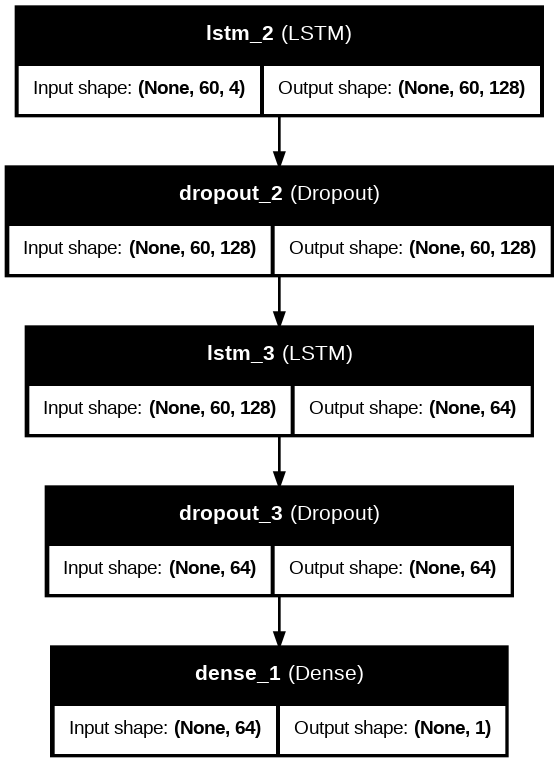

In [346]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Save model architecture as an image
plot_model(model,
           to_file='model_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           dpi=96)

# Display the image
Image(filename='model_architecture.png')


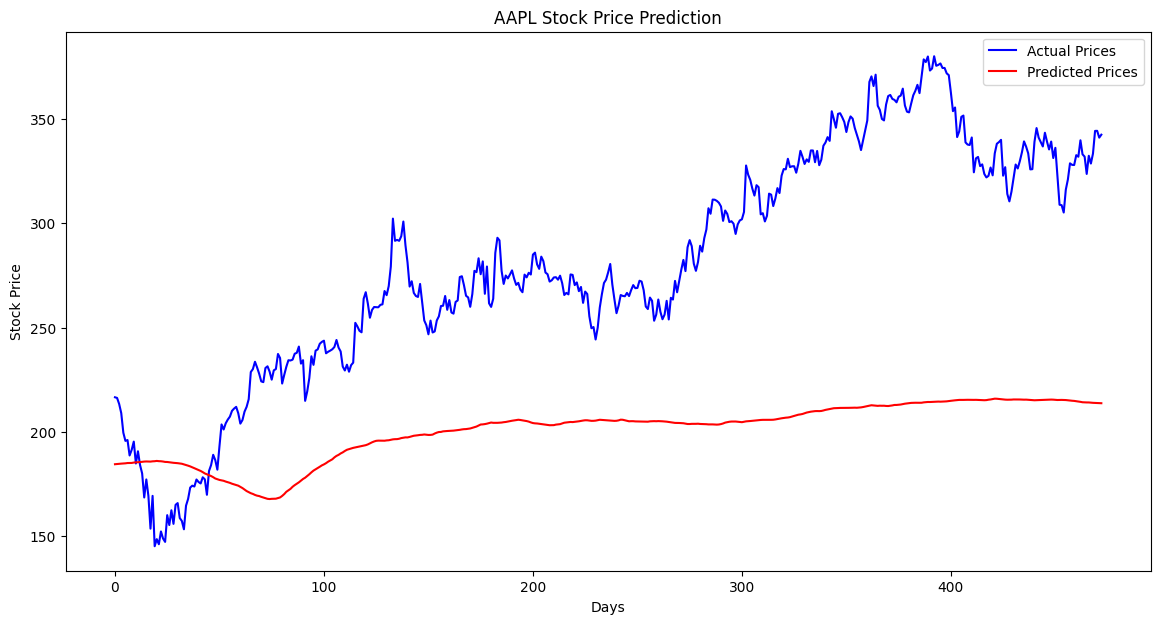

In [347]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(y_pred_inv, label='Predicted Prices', color='red')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [348]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 8373.1666
Mean Absolute Error (MAE): 82.2774
Mean Absolute Percentage Error (MAPE): 0.2763
Root Mean Squared Error (RMSE): 91.5050


# **5. Feature Engineering**

RSI stands for Relative Strength Index. It’s a popular technical indicator used to measure momentum — specifically whether an asset is overbought or oversold.

📉 Formula (simplified):

RSI = 100 − [100 / (1 + (Avg Gain / Avg Loss))]
Usually calculated over 14 days.

✅ Why Are We Computing RSI?

If RSI > 70 → the asset is likely overbought (price may fall)

If RSI < 30 → the asset is likely oversold (price may rise)

📌 It helps the model understand reversal zones and trend strength, which is useful for:

ML: better classification of “buy/sell/hold” periods
DL: learning price movement patterns
Portfolio Optimization: avoid allocating to overheated assets

In short: RSI adds “emotional context” to price data.

In [ ]:
'''# Function to compute RSI
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
    '''

In [ ]:
'''# Function to compute Z-score of returns
def compute_return_zscore(series, window=21):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std
    '''

In [ ]:
'''# Function to compute Drawdown
def compute_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    return (cumulative - peak) / peak
    '''

In [ ]:
'''# Function to add all the advanced features
def add_advanced_features(df):
    assets = ['AAPL', 'MSFT', 'AMZN', 'META']

    for asset in assets:
        close = df[f'{asset}_Close']

        df[f'{asset}_RSI'] = compute_RSI(close)
        df[f'{asset}_Return_ZScore'] = compute_return_zscore(close.pct_change())
        df[f'{asset}_Drawdown'] = compute_drawdown(close.pct_change())

    return df
    '''

In [ ]:
'''# Implementing the function above in the combined dataset - df :
df = add_advanced_features(df)

print(df)
'''

In [ ]:
'''# Calculate Mean Returns and Covariance Matrix
# Get daily returns only
returns = df[[f'{asset}_Daily Return' for asset in ['AAPL', 'MSFT', 'AMZN', 'META']]]

# Drop NaNs if RSI introduced them
returns.dropna(inplace=True)

# Mean returns (annualized)
mean_returns = returns.mean() * 252

# Covariance matrix (annualized)
cov_matrix = returns.cov() * 252

print("Mean Returns:\n", mean_returns)
print("\nCovariance Matrix:\n", cov_matrix)
'''

In [ ]:
'''# Adding PCA :
from sklearn.decomposition import PCA

# Keep only return/volatility-based features for PCA
features_for_pca = df[[col for col in df.columns if 'Return' in col or 'Volatility' in col]]
features_for_pca.dropna(inplace=True)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_for_pca)

# Create DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=features_for_pca.index)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='purple', alpha=0.5)
plt.title("PCA of Return & Volatility Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
'''

In [ ]:
'''df.head()
'''

In [ ]:
'''df.to_csv('Final.csv')
'''

# **6. Portfolio Optimization**

In [ ]:
'''# Installing PyPortfolioOpt
!pip install PyPortfolioOpt
'''

In [ ]:
'''# Importing the required functions
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
'''

In [ ]:
'''# DataFrame
df.head()
'''

In [ ]:
'''# Extract Close prices of new asset list
price_df = df_scaled[[f'{asset}_Close' for asset in ['GLD', 'AAPL', 'VTI', 'TLT']]]
price_df.columns = ['GLD', 'AAPL', 'VTI', 'TLT']  # Rename for PyPortfolioOpt compatibility
price_df.dropna(inplace=True)  # Ensure clean data
price_df
'''

In [ ]:
'''# Compute expected returns (mean annualized)
mu = mean_historical_return(price_df)                       # Annualized mean returns
# Compute covariance matrix using Ledoit-Wolf shrinkage
S = CovarianceShrinkage(price_df).ledoit_wolf()
'''

In [ ]:
'''# Optimizing Portfolio & Maximize Sharpe Ratio
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
'''

In [ ]:
'''# Compute Portfolio Metrics
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)
'''

In [ ]:
'''# Output Results
print("Optimal Weights:\n", cleaned_weights)
print(f"Expected Return: {expected_annual_return:.2%}")
print(f"Volatility: {annual_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
'''